In [609]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm

In [4]:
def plot_forest(dimensions, groupings, trees):
    forest = np.zeros(dimensions)
    for i,group in enumerate(groupings):
        forest[group[0], group[1]] = i

    x = np.linspace(0, 1, 3)
    y = np.linspace(0, 1, 3)

    fig, ax = plt.subplots()

    ax.set_aspect('equal', 'box')
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False)
    ax.pcolormesh(x, y, forest)
    

def is_contiguous(indices):
    # Check if indices list is empty
    if len(indices) == 0:
        return False
    
    # Convert indices to NumPy array for easier manipulation
    indices_array = np.array(indices)
    
    # Calculate differences between consecutive indices
    diff = np.diff(indices_array, axis=0)
    
    # Check if any difference is greater than 1
    if np.any(diff > 1):
        return False
    else:
        return True    

In [5]:
def generate_random_array(size, n=1):
    # Create an empty array of zeros
    array = np.zeros((size, size), dtype=int)
    col_indices = np.arange(size)
    # Generate random indices for placing ones
    # Place ones in each row and column
    for i in range(size):
        np.random.shuffle(col_indices)
        array[i, col_indices[0:n]] = 1
    
    return array

def adjacents(array, kernel):
    expanded_array = conv2d(array, kernel)
    return expanded_array

def find_adjacents(array):
    kernel = np.ones((3, 3), dtype=int)
    return np.where((adjacents(array, kernel) - array) * array > 0, 1, 0)

def conv2d(a, f):
    a = np.pad(a, ((1,1),(1,1)), mode='constant', constant_values=(0,0))
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

def find_available(array, n=1):
    kernel = np.ones((3, 3), dtype=int)
    opens_rowcol = array.copy()
    opens_rowcol[np.argwhere(np.where(np.sum(array, axis=1) > n-1, 1, 0)),:] = 1
    opens_rowcol[:,np.argwhere(np.where(np.sum(array, axis=0) > n-1, 1, 0))] = 1
    opens_nonadjacent = np.where(opens_rowcol + adjacents(array, kernel) > 0, 0, 1)
    opens_rowcol = np.where(opens_rowcol > 0, 0, 1)
    return opens_nonadjacent, opens_rowcol

def find_collisions(array, n=1):
    collisions = array.copy()
    collides = np.broadcast_to(np.where(np.sum(array, axis=0) > n, 1, 0), (array.shape[1], array.shape[0])) + np.broadcast_to(np.where(np.sum(array, axis=1) > n, 1, 0), array.shape).T + find_adjacents(array)
    collisions = np.where(collisions * collides > 0, 1, 0)
    return collisions
    
def shuffle_once(array, n=1):
    collisions = find_collisions(array, n=n)
    if np.any(collisions):
        collision_list = np.argwhere(collisions)
        opens_nonadjacent, opens_rowcol = find_available(array, n=n)
    else:
        return array, True
    if np.any(opens_nonadjacent):
        opens_list = np.argwhere(opens_nonadjacent)
    elif np.any(opens_rowcol):
        opens_list = np.argwhere(opens_rowcol)
    else:
        # print('no opens, perform random shuffle?')
        j = np.random.randint(0, len(collision_list))
        not_occupied = np.argwhere(np.where(array == 1, 0, 1))
        i = np.random.randint(0, len(not_occupied))
        array[collision_list[j][0], collision_list[j][1]] = 0
        array[not_occupied[i][0], not_occupied[i][1]] = 1
        return array, False

    i = np.random.randint(0, len(opens_list))
    j = np.random.randint(0, len(collision_list))
    # print(f"{collision_list[j]} > {opens_list[i]}")
    array[collision_list[j][0], collision_list[j][1]] = 0
    array[opens_list[i][0], opens_list[i][1]] = 1
    return array, False

def shuffle_until_complete(array, max_iters = 500, n=1):
    count = 0
    done = 0
    while not done:
        array, done = shuffle_once(array, n=n)
        count += 1
        if count > max_iters:
            break
    if done:
        print(f'completed in {count} iterations')
    else:
        print(f'exited early after {count} iterations')
    return array

def generate_tree_array(size, n=1):
    array = generate_random_array(size, n=n)
    array = shuffle_until_complete(array, n=n)
    return array

In [6]:
def get_adj_vals(array, i, j):
    adj_vals = []
    if i > 0:
        adj_vals.append(array[i-1, j])
    if i < array.shape[0] - 1:
        adj_vals.append(array[i+1, j])
    if j > 0:
        adj_vals.append(array[i, j-1])
    if j < array.shape[1] - 1:
        adj_vals.append(array[i, j+1])
    adj_vals = [x for x in adj_vals if x != 0]
    adj_vals = np.unique(np.array(adj_vals))
    return adj_vals


def get_initial_forest(trees):
    forest = np.zeros_like(trees)
    for i,tree in enumerate(np.argwhere(trees)):
        forest[tree[0], tree[1]] = i+1
    return forest

def grow_forest(forest, trees):
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=int)
    adjs = np.where(adjacents(np.where(forest>0,1,0), kernel=kernel) * np.where(forest==0, 1, 0)>0, 1, 0)
    adjs_list = np.argwhere(adjs)
    i = np.random.randint(0, len(adjs_list))
    val = get_adj_vals(forest, adjs_list[i][0], adjs_list[i][1])
    forest[adjs_list[i][0], adjs_list[i][1]] = val[np.random.randint(0, val.shape[0])]
    return forest

def generate_singular_forest(trees):
    # for tree in trees, assing each a value from 1 to n
    # choose an empty index at random, find the list of adjacent values, choose one at random, set index to that value
    # need to check that the minimum number of indices for each class is met, and that the number of indices for each class is not exceeded
    # for extrapolation to n tree problems, first derive singular regions for each tree, then merge regions based on adjacency:
        # probably derive an adjacency graph and then solve the merge problem and reassign indices to preserve exact tree condition
    forest = get_initial_forest(trees)
    
    while np.any(np.where(forest == 0, 1, 0)):
        forest = grow_forest(forest, trees)
        
    return forest

def i_to_index(i, size):
    return (i // size, i % size)

def index_to_i(index, size):
    return index[0] * size + index[1]

def increment_index(index, size):
    if index[1] == size - 1:
        if index[0] == size - 1:
            return None
        return (index[0] + 1, 0)
    else:
        return (index[0], index[1] + 1)
    
def find_available_forest(trees, forest, visited):
    kernel = np.ones((3, 3), dtype=int)
    opens = trees.copy()
    opens[np.argwhere(np.where(np.sum(trees, axis=1) > 0, 1, 0)),:] = 1
    opens[:,np.argwhere(np.where(np.sum(trees, axis=0) > 0, 1, 0))] = 1
    opens = np.where(opens + adjacents(trees, kernel) + visited > 0, 0, 1)
    for new_idx in np.argwhere(opens): # check if there is already a tree in the region
        region = forest[new_idx[0], new_idx[1]]
        if np.any(trees * np.where(forest == region, 1, 0)):
            opens[new_idx[0], new_idx[1]] = 0
    return opens
        
        
def place_tree(forest, visited=None, trees_pred=None, solutions=None):
    if trees_pred is None:
        trees_pred = np.zeros_like(forest)
    if solutions is None:
        solutions = []
    if visited is None:
        visited = np.zeros_like(forest)
        
    # plt.imshow(trees_pred)
    # plt.show()
    # time.sleep(1)
        
    # find available indices
    avail = find_available_forest(trees_pred, forest, visited)
    if np.any(avail):
        for avail_index in np.argwhere(avail):
            new_trees_pred = trees_pred.copy()
            new_trees_pred[avail_index[0], avail_index[1]] = 1
            result = place_tree(forest, visited, new_trees_pred, solutions)
            if result is not None:
                solutions = result[0]
                visited = result[1]
        if len(solutions) > 0:
            return solutions, visited
        else:
            return None
    else:
        if np.sum(trees_pred) == forest.shape[0]:
            solutions.append(trees_pred)
            visited = np.where(visited + trees_pred > 0, 1, 0)
            # print('solution found')
            return solutions, visited
        else:
            return None
    
    

In [433]:
def get_conflicting(array, i, j):
    adj_indices = []
    if i > 0 and j > 0:
        adj_indices.append([i-1, j-1])
    if i < array.shape[0] - 1 and j < array.shape[1] - 1:
        adj_indices.append([i+1, j+1])
    if j > 0 and i < array.shape[0] - 1:
        adj_indices.append([i+1, j-1])
    if j < array.shape[1] - 1 and i > 0:
        adj_indices.append([i-1, j+1])
        
    conflicting = np.ones_like(array)
    for adj_index in adj_indices:
        conflicting[adj_index[0], adj_index[1]] = 0
    conflicting[i,:] = 0
    conflicting[:,j] = 0
    return conflicting

def adjacents(array, kernel):
    expanded_array = conv2d(array, kernel)
    return expanded_array

def find_adjacents(array):
    kernel = np.ones((3, 3), dtype=int)
    return np.where((adjacents(array, kernel) - array) * array > 0, 1, 0)

def conv2d(a, f):
    a = np.pad(a, ((1,1),(1,1)), mode='constant', constant_values=(0,0))
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

def find_available(array, n=1):
    kernel = np.ones((3, 3), dtype=int)
    opens_rowcol = array.copy()
    opens_rowcol[np.argwhere(np.where(np.sum(array, axis=1) > n-1, 1, 0)),:] = 1
    opens_rowcol[:,np.argwhere(np.where(np.sum(array, axis=0) > n-1, 1, 0))] = 1
    opens_nonadjacent = np.where(opens_rowcol + adjacents(array, kernel) > 0, 0, 1)
    return opens_nonadjacent

def find_collisions(array, n=1):
    collisions = array.copy()
    collides = np.broadcast_to(np.where(np.sum(array, axis=0) > n, 1, 0), (array.shape[1], array.shape[0])) + np.broadcast_to(np.where(np.sum(array, axis=1) > n, 1, 0), array.shape).T + find_adjacents(array)
    collisions = np.where(collisions * collides > 0, 1, 0)
    return collisions
    
def shuffle_once(array, n=1):
    collisions = find_collisions(array, n=n)
    if np.any(collisions):
        collision_list = np.argwhere(collisions)
        opens_nonadjacent, opens_rowcol = find_available(array, n=n)
    else:
        return array, True
    if np.any(opens_nonadjacent):
        opens_list = np.argwhere(opens_nonadjacent)
    elif np.any(opens_rowcol):
        opens_list = np.argwhere(opens_rowcol)
    else:
        # print('no opens, perform random shuffle?')
        j = np.random.randint(0, len(collision_list))
        not_occupied = np.argwhere(np.where(array == 1, 0, 1))
        i = np.random.randint(0, len(not_occupied))
        array[collision_list[j][0], collision_list[j][1]] = 0
        array[not_occupied[i][0], not_occupied[i][1]] = 1
        return array, False

    i = np.random.randint(0, len(opens_list))
    j = np.random.randint(0, len(collision_list))
    # print(f"{collision_list[j]} > {opens_list[i]}")
    array[collision_list[j][0], collision_list[j][1]] = 0
    array[opens_list[i][0], opens_list[i][1]] = 1
    return array, False

def shuffle_until_complete(array, max_iters = 500, n=1):
    count = 0
    done = 0
    while not done:
        array, done = shuffle_once(array, n=n)
        count += 1
        if count > max_iters:
            break
    if done:
        print(f'completed in {count} iterations')
    else:
        print(f'exited early after {count} iterations')
    return array

def generate_tree_array(size, n=1):
    array = generate_random_array(size, n=n)
    array = shuffle_until_complete(array, n=n)
    return array
        
def grow_tree_array(m, n, maxiter = 1000000):
    trees = np.zeros((m,m), dtype=int)
    count = 0
    with tqdm.tqdm(total=maxiter) as pbar:
        while np.sum(trees) < n*m and count < maxiter:
            avail = find_available(trees, n=n)
            if np.any(avail):
                avail_list = np.argwhere(avail)
                i = np.random.randint(0, avail_list.shape[0])
                trees[avail_list[i][0], avail_list[i][1]] = 1
                continue
            else:
                opens = np.where(trees == 0, 1, 0)
                opens_list = np.argwhere(opens)
                i = np.random.randint(0, opens_list.shape[0])
                
                trees = trees * get_conflicting(trees, opens_list[i][0], opens_list[i][1])            
                trees[opens_list[i][0], opens_list[i][1]] = 1
            count += 1
            if count % 1000 == 0:
                pbar.update(1000)
            
    pbar.close()
    if count < maxiter:
        print(f'completed in {count} iterations')
        return trees
    else:
        print(f'exited early after {count} iterations')
        return 0
        
        

In [434]:
grow_tree_array(10, 2, maxiter = 1000000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

completed in 160 iterations


array([[0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]])

 38%|███▊      | 378000/1000000 [01:38<02:41, 3849.23it/s]

completed in 378011 iterations


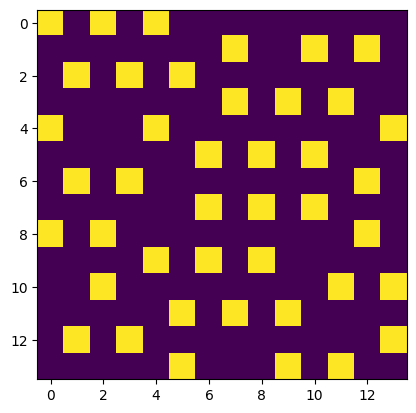

In [437]:
plt.imshow(grow_tree_array(14, 3, maxiter = 1000000))

time = 0.0007958412170410156


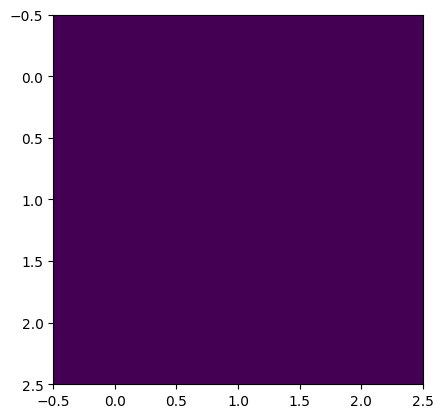

In [438]:
start = time.time()
singular_forest = generate_singular_forest(trees)
print(f"time = {time.time() - start}")
plt.imshow(singular_forest)

time = 0.01349186897277832


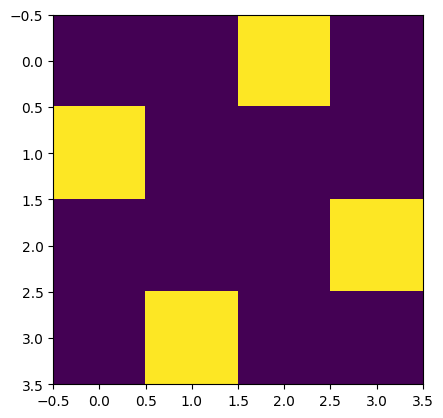

In [36]:
start = time.time()
solutions, visited = place_tree(singular_forest)
print(f"time = {time.time() - start}")
for solution in solutions:
    plt.imshow(solution)
    plt.show()

In [10]:
solutions

[array([[0, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0]]),
 array([[0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])]

  0%|          | 0/1000000 [00:00<?, ?it/s]

completed in 605 iterations


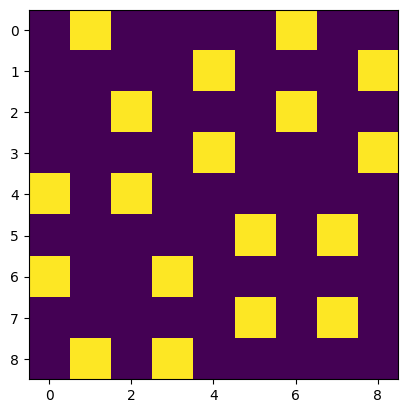

In [466]:
trees = grow_tree_array(9, 2, maxiter = 1000000)

plt.imshow(trees)

time = 0.007445096969604492


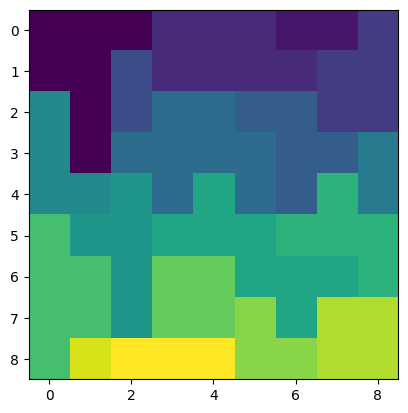

In [467]:
start = time.time()
singular_forest = generate_singular_forest(trees)
print(f"time = {time.time() - start}")
plt.imshow(singular_forest)

In [468]:
def generate_singular_forest(trees):
    forest = get_initial_forest(trees)
    
    while np.any(np.where(forest == 0, 1, 0)):
        forest = grow_forest(forest, trees)
        
    return forest

def calc_adjacency_list(forest):
    adj_list = []
    for region in np.unique(forest):
        for index in np.argwhere(forest == region):
            adj_vals = get_adj_vals(forest, index[0], index[1])
            for val in adj_vals:
                adj_list.append((region, val))
    adj_list = list(set(adj_list))
    adj_list = sorted(adj_list, key=lambda x: x[0] * forest.shape[0] + x[1])
    return adj_list


def generate_nforest(trees):
    n = np.sum(trees)//trees.shape[0]
    forest = get_initial_forest(trees)
    
    adjacency_list = calc_adjacency_list(forest)
    
    while np.any(np.where(forest == 0, 1, 0)):
        forest = grow_forest(forest, trees)
        
    return forest


def adj_list_to_matrix(adjacency_list):
    adj_matrix = np.zeros((adjacency_list[-1][0], adjacency_list[-1][1]))
    for edge in adjacency_list:
        adj_matrix[edge[0]-1, edge[1]-1] = 1
    return adj_matrix

def merge_regions(adjacency_list):
    done = 0
    while not done:
        merged = []
        shuffled_list = np.array(adjacency_list.copy())
        np.random.shuffle(shuffled_list)
        for edge in list(shuffled_list):
            if edge[0] == edge[1]:
                continue
            if edge[0] in merged or edge[1] in merged:
                continue
            else:
                merged.append(edge[0])
                merged.append(edge[1])
        if len(merged) == max(adjacency_list, key=lambda x: x[0])[0]:
            done = 1
        else:
            print('failed')
    return merged

In [469]:
adjacency_list = calc_adjacency_list(singular_forest)

In [548]:
adj_mat = adj_list_to_matrix(adjacency_list)
np.sum(adj_mat, axis=0)


array([5., 3., 7., 5., 4., 6., 7., 4., 4., 7., 7., 5., 4., 5., 5., 4., 2.,
       5.])

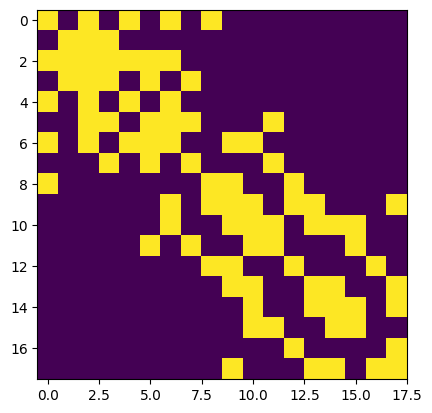

In [549]:
plt.imshow(adj_list_to_matrix(adjacency_list))

In [473]:
def calc_merges(adjacency_list, n=2, maxiter = 100000):
    done = 0
    count = 0
    while not done:
        merged = []
        shuffled_list = np.array(adjacency_list.copy())
        np.random.shuffle(shuffled_list)
        for edge in list(shuffled_list):
            
            # Do: for every merge step, check if it disconnects the graph: if so, don't merge
            # checking if the graph is disconnected can be done on the adjacency matrix, if the identity is subtracted,
            # then any column that contains only zeros is a disconnected region - taking the product of column sums will reveal this
            
            if edge[0] == edge[1]:
                continue
            if edge[0] in merged or edge[1] in merged:
                continue
            else:
                merged.append(edge[0])
                merged.append(edge[1])
            
            if n > 2: # for n > 2, keep adding an adjacent region until we reach n,
                for i in range(n-2):
                    for j in shuffled_list:
                        if j[0] == edge[0] or j[0] == edge[1]:
                            if j[0] not in merged:
                                merged.append(j[0])
                                break
                        if j[1] == edge[0] or j[1] == edge[1]:
                            if j[1] not in merged:
                                merged.append(j[1])
                                break
            
            
            
        if len(merged) == max(adjacency_list, key=lambda x: x[0])[0]:
            done = 1
        else:
            count += 1
            if count > maxiter:
                print(f'failed after {count} iterations')
                return 0
            if count % 1000 == 0:
                print(f'count = {count}')
    merged = [tuple(merged[i:i+n]) for i in range(0, len(merged), n)]
    print(f'merge pattern found after {count} iterations')
    return merged

def merge_forest(forest, adjacency_list):
    n = np.amax(forest)//forest.shape[0]
    merged = calc_merges(adjacency_list, n)
    if merged == 0:
        return 0
    new_forest = np.zeros_like(forest)
    for i,merge in enumerate(merged):
        for j in range(n):
            new_forest = np.where(forest == merge[j], i+1, new_forest)
    return new_forest

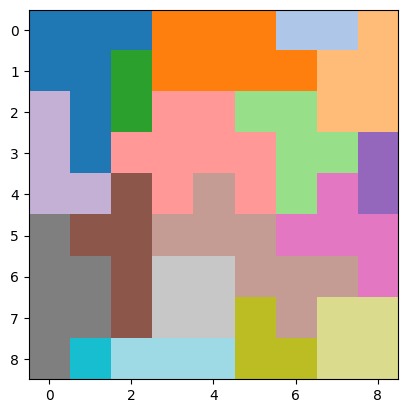

In [474]:
plt.imshow(singular_forest, cmap='tab20')

In [475]:
merged = merge_forest(singular_forest, adjacency_list)

merge pattern found after 1 iterations


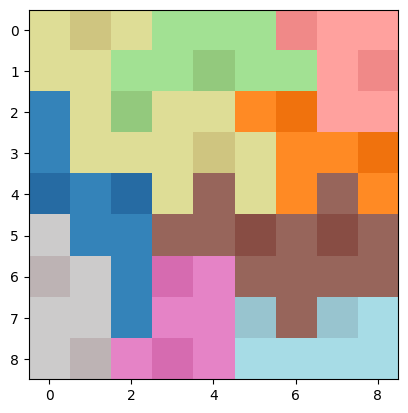

In [476]:
plt.imshow(merged, cmap='tab20')
plt.imshow(trees, alpha=0.1, cmap='Reds')
plt.show()

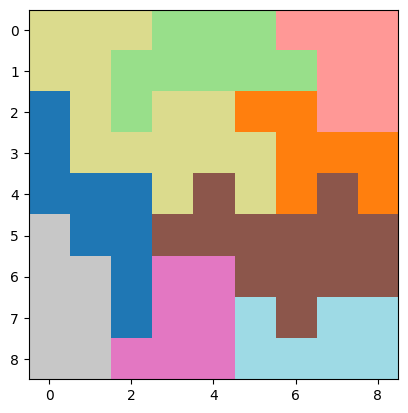

In [477]:
plt.imshow(merged, cmap='tab20')

In [478]:
def calc_merges(adjacency_list, n=2, maxiter = 100000):
    done = 0
    count = 0
    merged = []
    adj_mat = adj_list_to_matrix(adjacency_list)
    # degrees = np.sum(adj_mat, axis=0)
    
    ordered_indices = np.argsort(np.sum(adj_matrix, axis=0))
    while not done:
        for index in list(ordered_indices):
            for adj_region in range(n):
                for edge in adjacency_list:
            
            
            if edge[0] == edge[1]:
                continue
            if edge[0] in merged or edge[1] in merged:
                continue
            else:
                merged.append(edge[0])
                merged.append(edge[1])
            
            if n > 2:
        merged = []
        adj_mat = adj_list_to_matrix(adjacency_list)
        # degrees = np.sum(adj_mat, axis=0)
        
        ordered_indices = np.argsort(np.sum(adj_matrix, axis=0))
        merged = [tuple(merged[i:i+n]) for i in range(0, len(merged), n)]
        
    print(f'merge pattern found after {count} iterations')
    return merged

In [479]:
def plot_forest(forest, trees, solution = False, cmap='tab20'):
    x = np.linspace(0, forest.shape[0]-1, forest.shape[0])
    y = np.linspace(0, forest.shape[1]-1, forest.shape[1])
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    ax.set_aspect('equal', 'box')
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False)
    ax.pcolormesh(x, y, forest, cmap=cmap, edgecolors='white', linewidths=150/1024/32)
    
    if solution:
        ax.scatter(np.argwhere(trees)[:,1], np.argwhere(trees)[:,0], color='k', marker='*', s=50, zorder=10)

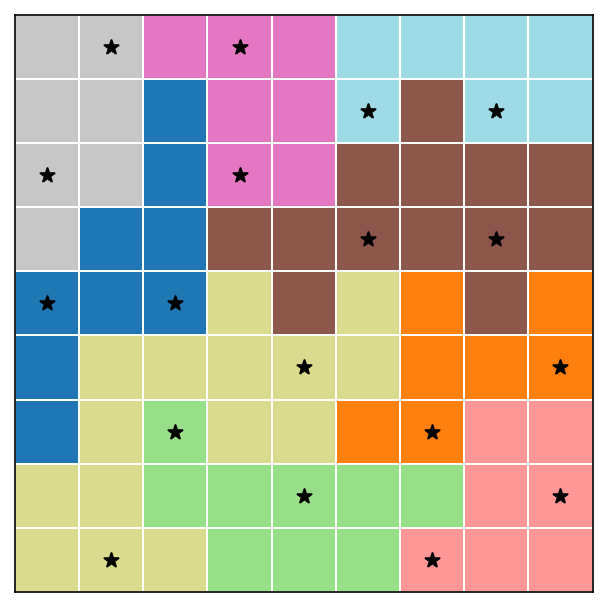

In [480]:
plot_forest(merged, trees, solution=True)

In [559]:
adj_matrix = adj_list_to_matrix(adjacency_list)

In [560]:
np.sum(adj_matrix * np.arange(adj_matrix.shape[0]), axis=0)

array([ 0.,  3., 14., 15., 16., 30., 42., 28., 32., 63., 70., 55., 48.,
       65., 70., 60., 32., 85.])

In [561]:
np.argsort(np.sum(adj_matrix * np.arange(adj_matrix.shape[0]), axis=0))

array([ 0,  1,  2,  3,  4,  7,  5, 16,  8,  6, 12, 11, 15,  9, 13, 10, 14,
       17])

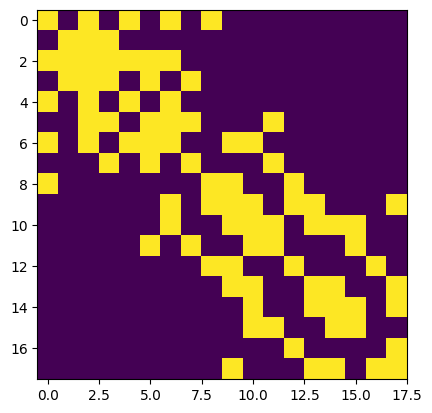

In [562]:
plt.imshow(adj_matrix)

In [589]:
np.argsort(np.sum(a * np.arange(a.shape[0]), axis=0))

array([ 0,  1,  2,  3,  4,  7,  5, 16,  8,  6, 12, 11, 15,  9, 13, 10, 14,
       17])

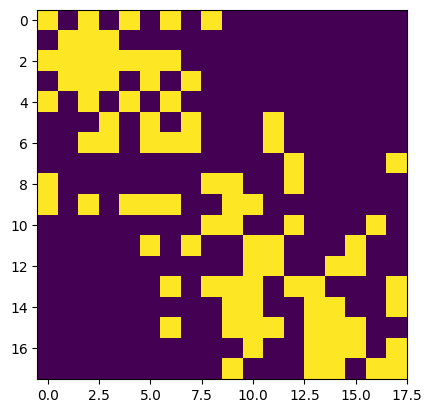

In [608]:
a = adj_matrix #* np.tri(adj_matrix.shape[0], k=-1)#- np.eye(adj_matrix.shape[0])
b = a[[np.argsort(np.sum(a * np.arange(a.shape[0]), axis=0)), np.argsort(np.sum(a * np.arange(a.shape[0]), axis=0))]]
# c = b[:,np.argsort(np.sum(a * np.arange(a.shape[0]), axis=1))]
plt.imshow(b[0])
# plt.imshow(a)

In [596]:
a[[[0,1],[0,1]]].shape

(2, 2, 18)

In [592]:
a

array([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
        0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 0.],
       [0., 0., 0., 0

In [558]:
np.argsort(np.array(a).mean(0))

array([16,  1,  8, 15,  4, 12,  7, 14, 13, 11,  0,  3, 17,  5,  9,  6,  2,
       10])